In [72]:
import pydicom
import matplotlib.pyplot as plt

meiyou zhuzhi?

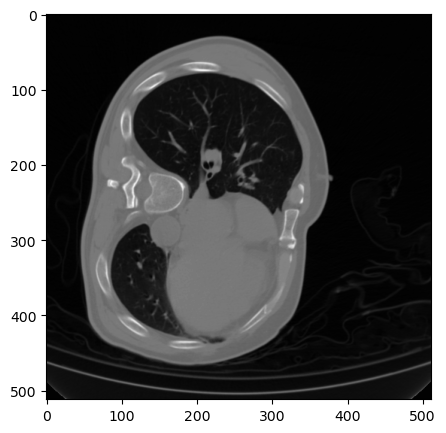

In [13]:
ds=pydicom.dcmread('/mnt/sda/data/FudanCancer/20-RFA-ZYBO/20-zyb-CT/IMG-0013-00001.dcm')
plt.figure(figsize=(5,5))
plt.imshow(ds.pixel_array,cmap=plt.cm.gray)
plt.show()

In [8]:
print(ds)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.156.112605.189250947047623.210817135123.4.8152.12828
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.9.3811.1.5.6
(0002, 0013) Implementation Version Name         SH: 'PYNETDICOM_156'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELICAL']
(0008, 0012) Instance Creation Date              DA: '20210817'
(0008, 0013) Instance Creation Time              TM: '215118'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(000

In [27]:
import numpy as np
import pandas as pd
import pydicom
import os
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

INPUT_FOLDER = '/mnt/sda/data/FudanCancer/liver/' #/20-RFA-ZYBO/20-zyb-CT/
patients = os.listdir(INPUT_FOLDER)
patients.sort()
patients

['10-sp-CT', '8-wrm-CT', '9-cbs-CT']

In [29]:
def load_scan(path):
    slices=[pydicom.dcmread(path+'/'+s)for s in os.listdir(path)]#但是实际上还有一层
    slices.sort(key=lambda x:float(x.ImagePositionPatient[2]))#进行坐标变换
    try:
        slice_thickness=(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
         slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
            
    for s in slices:
         s.SliceThickness = slice_thickness
    return slices

In [30]:
def get_pixels_hu(slices):
    
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope!=1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    return np.array(image, dtype=np.int16)

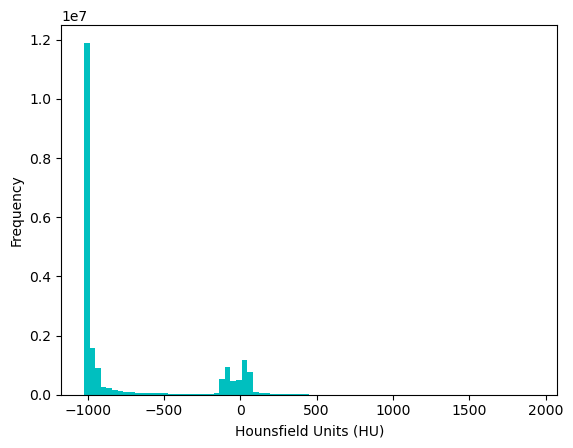

In [31]:
first_patient=load_scan(INPUT_FOLDER+patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

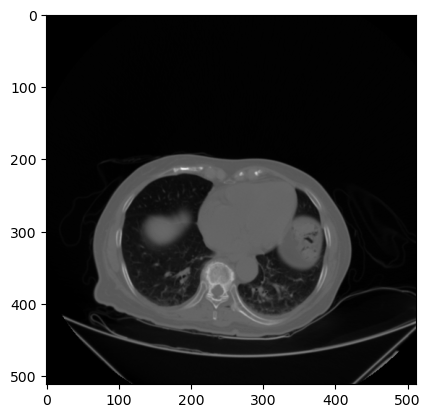

In [35]:
plt.imshow(first_patient_pixels[66], cmap=plt.cm.gray)
plt.show()

In [50]:
#对数据进行重采样的操作
def resample(image, scan, new_spacing=[1,1,1]):
    spacing = np.array([scan[0].SliceThickness,scan[0].PixelSpacing,scan[0].PixelSpacing[1]], dtype=np.float32)
    resize_factor = spacing / new_spacing  #改变分辨率后的图像像素个数大小
    new_real_shape = image.shape * resize_factor  #
    new_shape = np.round(new_real_shape)  #对计算后的矩阵进行round
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest') #进行插值缩放
    
    return image, new_spacing

In [51]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [52]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [53]:
plot_3d(first_patient_pixels, 400)

ValueError: too many values to unpack (expected 2)

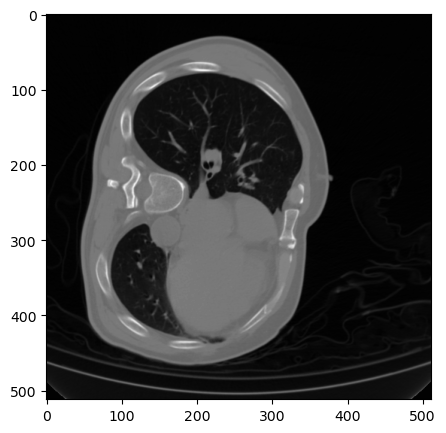

In [17]:
z=pydicom.read_file('/mnt/sda/data/FudanCancer/20-RFA-ZYBO/20-zyb-CT/IMG-0013-00001.dcm')
plt.figure(figsize=(5,5))
plt.imshow(z.pixel_array,cmap=plt.cm.gray)
plt.show()

In [54]:
import SimpleITK as sitk

In [57]:
path='/mnt/sda/data/FudanCancer/20-RFA-ZYBO/20-zyb-CT' #/IMG-0013-00001.dcm

In [62]:
reader=sitk.ImageSeriesReader()
dcm_names=reader.GetGDCMSeriesFileNames(path)
reader.SetFileNames(dcm_names)
ima=reader.Execute()

In [65]:
#print(ima)
size=ima.GetSize()

Image (0x5b56060)
  RTTI typeinfo:   itk::Image<int, 3u>
  Reference Count: 1
  Modified Time: 5815
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1854
  UpdateMTime: 5811
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 111]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 111]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 111]
  Spacing: [0.683594, 0.683594, 3]
  Origin: [-155.36, 174.658, -1395.09]
  Direction: 
0 1 0
-1 0 0
0 0 1

  IndexToPointMatrix: 
0 0.683594 0
-0.683594 0 0
0 0 3

  PointToIndexMatrix: 
0 -1.46286 0
1.46286 0 0
0 0 0.333333

  Inverse Direction: 
0 -1 0
1 0 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x2d81b70)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, int>
      Refer

In [66]:
size=ima.GetSize()
print("Image size:", size)
spacing = ima.GetSpacing()
print("Image spacing:", spacing)
direction = ima.GetDirection()
print("Image direction:", direction)
origin = ima.GetOrigin()
print("Image origin:", origin)

Image size: (512, 512, 111)
Image spacing: (0.68359375, 0.68359375, 3.0)
Image direction: (0.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0)
Image origin: (-155.359879, 174.658203, -1395.08765)


In [67]:
marray=sitk.GetArrayFromImage(ima)
print(marray.shape)
site

(111, 512, 512)


In [76]:
path2='/mnt/sda/data/FudanCancer/20-RFA-ZYBO/20-zyb-CT/IMG-0013-00001.dcm' 
#path2='/mnt/sda/data/FudanCancer/20-RFA-ZYBO/20-zyb-CT/zyb-CT.nii' 
ima2=sitk.ReadImage(path2)
print(ima2.GetSize())

(512, 512, 1)


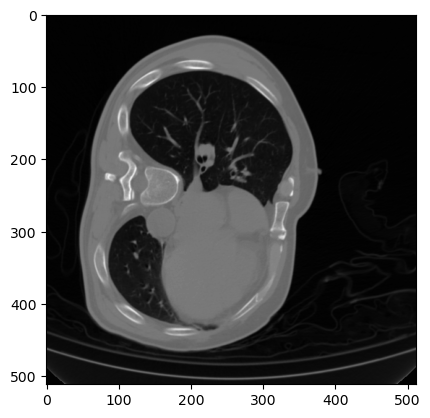

In [84]:
ima22=sitk.GetArrayFromImage(ima2)
ima23=ima22.transpose(1,2,0)
plt.imshow(ima23,cmap=plt.cm.gray)

In [81]:
le

512